# Démo de Régression Linéaire -- pour le Cours Magistral #1

Attention, ce notebook contient des erreurs méthodologiques (pas de train/test split par exemple), c'est une première démo très primaire juste pour montrer qq outils très simples

In [1]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.model_selection
import sklearn.linear_model
import sklearn.preprocessing

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.ion()

### Remarque: les parties sont indépendantes

# Chargement des données, vocabulaire

Puisqu'on n'a jamais fait de régression linéaire en TD, et qu'on en a parlé, mais assez rapidement, en cours, on commence par une illustration de ce que peut faire la régression linéaire, sur un cas concret:

C'est le fameux *boston house market* data set: 

https://archive.ics.uci.edu/ml/machine-learning-databases/housing/

Mis sur Kaggle plus récemment:
https://www.kaggle.com/vikrishnan/boston-house-prices/ 

On s'inspire assez amplement de la solution de l'autrice (Kaggle) du dataset, au moins pour ce qui est du chargement des données:
https://www.kaggle.com/vikrishnan/house-sales-price-using-regression

En gros, on a des données sur différents quartiers de Boston, et pour chaque quartier, on a le prix médian des maisons (ou appartements). On cherche à comprendre comment certains facteurs du voisinage déterminent le prix des maisons d'un quartier. Ou bien plus simplement, dans le cadre de ce DM, on se contente de tenter de prédire le prix des maisons en fonction des données fournies en entrée.

Comme d'habitude, on a $N$ points dans l'ensemble d'entraînement, chaque point de donnée est en dimension $D$, et les labels à prédire sont des valeurs continues, $y_n\in \mathbb{R}$.

Les attributs sont décrits ainsi à l'origine:

7. Attribute Information:

    1. CRIM      per capita crime rate by town
    2. ZN        proportion of residential land zoned for lots over 25,000 sq.ft.
    3. INDUS     proportion of non-retail business acres per town
    4. CHAS      Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
    5. NOX       nitric oxides concentration (parts per 10 million)
    6. RM        average number of rooms per dwelling
    7. AGE       proportion of owner-occupied units built prior to 1940
    8. DIS       weighted distances to five Boston employment centres
    9. RAD       index of accessibility to radial highways
    10. TAX      full-value property-tax rate per USD10,000
    11. PTRATIO  pupil-teacher ratio by town
    12. B        $1000(Bk - 0.63)^2$ where $Bk$ is the proportion of blacks by town
    13. LSTAT    percentage lower status of the population
    14. MEDV     Median value of owner-occupied homes in 1000 USD
    

## Partie 1.0 - petite démo de statistiques descriptives

Ici, vous n'avez rien à faire, juste à lire ce qu'on vous présente (ce sera bien pratique pour les projets!)

In [3]:
# chargement des données
filename = "TP-RegressionLineaire-data-partie1-housing.csv"
names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
dataset = pd.read_csv(filename, delim_whitespace=True, names=names)
dataset.head(4)

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242.0   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242.0   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4

# Vocabulaire

citer le nom de deux features.

quel est le nombre de points de données?

quelle est la dimension des données ? Quel est le nombre de features ?

Quel va etre le type de tache ? (supervisé ou non ? Classification ou Regression ou ... ?)

In [4]:
dataset

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0    0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
1    0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242.0   
2    0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242.0   
3    0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222.0   
4    0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222.0   
..       ...   ...    ...   ...    ...    ...   ...     ...  ...    ...   
501  0.06263   0.0  11.93     0  0.573  6.593  69.1  2.4786    1  273.0   
502  0.04527   0.0  11.93     0  0.573  6.120  76.7  2.2875    1  273.0   
503  0.06076   0.0  11.93     0  0.573  6.976  91.0  2.1675    1  273.0   
504  0.10959   0.0  11.93     0  0.573  6.794  89.3  2.3889    1  273.0   
505  0.04741   0.0  11.93     0  0.573  6.030  80.8  2.5050    1  273.0   

     PTRATIO       B  LSTAT  MEDV  
0       15.3  396.90   4.98  24.0  
1       17.8  396.90   9.14  21.6  
2       17.8  392.83   4.03  34.7  
3       18.7  394.63   2.94  33.4  
4       18.7  396.90   5.33  36.2  
..       ...     ...    ...   ...  
501     21.0  391.99   9.67  22.4  
502     21.0  396.90   9.08  20.6  
503     21.0  396.90   5.64  23.9  
504     21.0  393.45   6.48  22.0  
505     21.0  396.90   7.88  11.9  

[506 rows x 14 columns]

In [5]:
x_d = dataset['RM'].values  ## feature ou colonne numero d, ici indiquee par le label "RM"
m_d= np.mean(x_d) #moyenne
s_d = np.std(x_d) # ecart type


In [6]:
m_d, s_d

(6.284634387351779, 0.7019225143345689)

In [7]:
x_standardized_d = (x_d-m_d)/s_d

m_d= np.mean(x_standardized_d)
s_d = np.std(x_standardized_d)

m_d, s_d

(-1.0882818581305882e-16, 0.9999999999999999)

In [8]:
dataset.describe()

CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std     28.148861    2.105710    8.707259  168.537116    2.164946   91.294864   
min      2.900000    1.129600    1.000000  187.000000   12.600000    0.320000   
25%     45.025000    2.100175    4.000000  279.000000   17.400000  375.377500   
50%     77.500000    3.207450    5.000000  330.000000   19.050000  391.440000   
75%     94.075000    5.188425   24.000000  666.000000   20.200000  396.225000   
max    100.000000   12.126500   24.000000  711.000000   22.000000  396.900000   

            LSTAT        MEDV  
count  506.000000  506.000000  
mean    12.653063   22.532806  
std      7.141062    9.197104  
min      1.730000    5.000000  
25%      6.950000   17.025000  
50%     11.360000   21.200000  
75%     16.955000   25.000000  
max     37.970000   50.000000

In [9]:
## les colonnes (sauf la dernière) correspondent aux variables explicatives du prix (features)
features = dataset.columns[:-1]

# la derniere colonne, MEDV, correspond à la valeur médiane (Median Value) des maisons dans un quartier
label = dataset.columns[-1]

In [10]:
features, label

(Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
        'PTRATIO', 'B', 'LSTAT'],
       dtype='object'),
 'MEDV')

In [11]:
print(dataset.shape)

(506, 14)


In [12]:
## on convertit les tableaux pandas en tabeaux numpy
X = dataset[features].values
Y = dataset[label].values

In [13]:
X.shape, Y.shape

((506, 13), (506,))

## Fit par regression lineaire (brutale)

Ici on n'est pas très fin, mais bon, c'est pour avoir un exemple concret:

In [14]:
monModele = sklearn.linear_model.LinearRegression()

In [15]:
monModele.coef_  # les valeurs du vecteur a dans ma fonction ax+b

AttributeError: 'LinearRegression' object has no attribute 'coef_'

In [16]:
monModele.fit(X, Y) ## attention, ne faites pas ça chez vous ! C'est tres dangereux d'entrainer sur toutes les données ! On le fait ici juste car c'est le premier cours !


LinearRegression()

In [17]:
monModele.coef_, monModele.intercept_  # vec(a), b 

(array([-1.08011358e-01,  4.64204584e-02,  2.05586264e-02,  2.68673382e+00,
        -1.77666112e+01,  3.80986521e+00,  6.92224640e-04, -1.47556685e+00,
         3.06049479e-01, -1.23345939e-02, -9.52747232e-01,  9.31168327e-03,
        -5.24758378e-01]),
 36.459488385090125)

In [18]:
Y_train_pred1 = monModele.predict(X)
print("train error", sklearn.metrics.mean_squared_error(Y_train_pred1, Y))

train error 21.894831181729206


In [19]:
Y_train_pred1.shape

(506,)

In [20]:
    monModele.coef_.shape, X.shape

((13,), (506, 13))

In [21]:
(X @ monModele.coef_ ).shape

(506,)

In [22]:
(monModele.coef_ @ X.T).shape

(506,)

In [23]:
# on peut le calculer à la main :
Y_train_pred2 = monModele.intercept_ + X @ monModele.coef_ 
print("train error", sklearn.metrics.mean_squared_error(Y_train_pred2, Y))

train error 21.894831181729206


In [24]:
Y_train_pred2- Y_train_pred1

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [27]:
Y_train_pred=Y_train_pred1

## Représentation du résultat (y prédit) vs. la vérité terrain


In [28]:
xmin= min(Y.min(), Y_train_pred.min() )-1
xmax= max(Y.max(), Y_train_pred.max() )+1

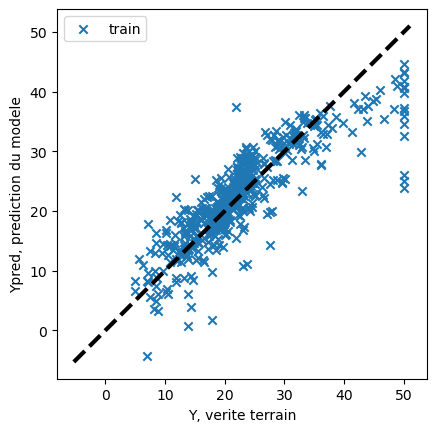

In [29]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
plt.scatter(Y, Y_train_pred, marker='x', label='train')
plt.plot([xmin,xmax], [xmin,xmax], lw=3, color='k', ls='--') ## droite separatrice d'equation x2=x1

# ?labe -> xlabel ou ylabel: a vous de voir
plt.xlabel('Y, verite terrain')
plt.ylabel('Ypred, prediction du modele') 
plt.legend()
ax.set_aspect('equal') # on veut une figure carrée et pas allongée.
# plt.xlim([xmin,xmax])
# plt.ylim([xmin,xmax])

# Statisiques descriptives

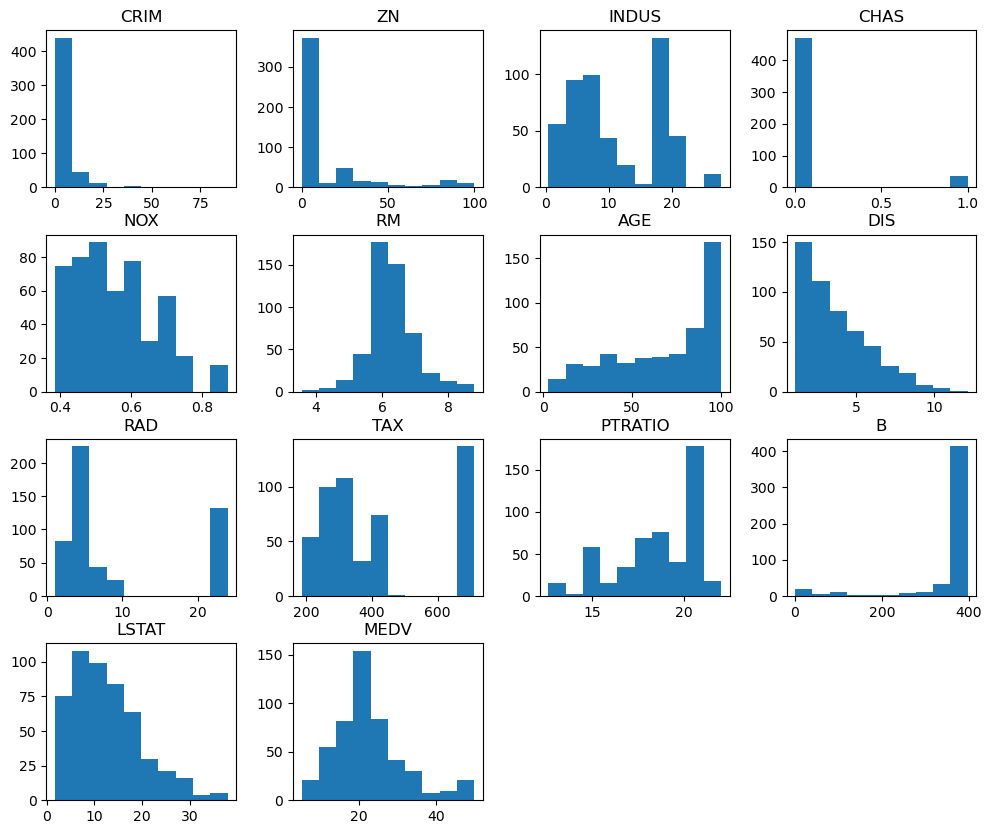

In [30]:
# Data visualizations

# histograms
dataset.hist(bins=10,figsize=(12,10),grid=False);

In [31]:
# on calcule les corréaltions entre colonnes (coeff. de correlation de Pearson)
pd.set_option('precision', 2)
corre = dataset.corr(method='pearson')
corre

OptionError: Pattern matched multiple keys

In [ ]:
plt.imshow(corre)